# MOVIE RECOMMENDATION 2022
© Explore Data Science Academy

<br></br>

<div align="center" style="width: 700px; font-size: 80%; text-align: center; margin-left: 100px">
<img src="resources/imgs/Image_header.png"
     alt="Collaborative-based Filtering - Utility Matrix"
     style="float: center; padding-bottom=0.5em"
     width=700px/>
</div>

#### Development Team

1. Mercy Milkah Gathoni
2. Linda Kelida
3. Samuel Mijan
4. Sipho Lukhele
5. Jessica Njuguna

<a id="one"></a>
## 1. INTRODUCTION

### Problem Statement

In today’s technology driven world, recommender systems are socially and economically critical to ensure that individuals can make optimised choices surrounding the content they engage with on a daily basis. One application where this is especially true is movie recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being personalised recommendations - generating platform affinity for the streaming services which best facilitates their audience's viewing.

<a id="cont"></a>
### Table of Contents

**<a href=#one>1. Introduction</a>**
- Problem Statement
- Table of Contents
- Summary
- Preliminary Activities


**<a href=#two>2. Exploratory Data Analysis</a>**


**<a href=#three>3. Feature Engineering</a>**
- Dealing with Null Values
- Data Scaling
- Dimension Reduction


**<a href=#four>4. Modelling</a>**
- Logging Comet Experiments


**<a href=#five>5. Model Perfomance Comparison</a>**


**<a href=#six>6. Model Explanations</a>**


**<a href=#seven>7. Conclusion</a>**


**<a href=#eight>8. Appendix</a>**
- Kaggle Submissions

### Summary

**Agenda:**

**Deliverables:**

**Results:**

### Preliminary Activities

#### Comet set up

In [1]:
from comet_ml import Experiment

In [2]:
experiment = Experiment(api_key="MHehhbanm9HbbvXptMjQ0hinn",
    project_name="movie-recommender-2022",
    workspace="jessica-njuguna")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jessica-njuguna/movie-recommender-2022/3add8bf61fc6432cb0bf32d6e95bacc5



#### Importing Packages

In [4]:
#A00

# Libraries for data loading, data manipulation
import pandas as pd
import re

# Libraries for mathematical analyses
import numpy as np

#Libraries for Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)
import missingno as msno


from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

import operator
import heapq
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp

#Libraries to test accuracy
from surprise import accuracy

#Library for creating pickle files of the models
import pickle

#### Importing Data

In [5]:
#A00

raw_train_df = pd.read_csv('/home/explore-student/unsupervised_data/unsupervised_movie_data/train.csv')
raw_test_df = pd.read_csv('/home/explore-student/unsupervised_data/unsupervised_movie_data/test.csv')
raw_movies_df = pd.read_csv('/home/explore-student/unsupervised_data/unsupervised_movie_data/movies.csv')
raw_tags_df = pd.read_csv('/home/explore-student/unsupervised_data/unsupervised_movie_data/tags.csv')
raw_links_df = pd.read_csv('/home/explore-student/unsupervised_data/unsupervised_movie_data/links.csv')
raw_imdb_df = pd.read_csv('/home/explore-student/unsupervised_data/unsupervised_movie_data/imdb_data.csv')
raw_getags_df = pd.read_csv('/home/explore-student/unsupervised_data/unsupervised_movie_data/genome-tags.csv')
raw_gescores_df = pd.read_csv('/home/explore-student/unsupervised_data/unsupervised_movie_data/genome-scores.csv')

<a id="two"></a>
## 2. EXPLORATORY DATA ANALYSIS
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

The datasets took a long time to load, this suggests that the files may be large. Let us view the size of each dataset using the function below:

In [6]:
def view_memory_usage(df, verbose = True):
    mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage is {:.2f} Mb \n".format(mem))
    return

In [7]:
print('Train df:')
view_memory_usage(raw_train_df, verbose = True)
print('Test df:')
view_memory_usage(raw_test_df , verbose = True)
print('Movies df:')
view_memory_usage(raw_movies_df, verbose = True)
print('Tags df:')
view_memory_usage(raw_tags_df, verbose = True)
print('Links df:')
view_memory_usage(raw_links_df, verbose = True)
print('IMDB df:')
view_memory_usage(raw_imdb_df, verbose = True)
print('Genome_tags df:')
view_memory_usage(raw_getags_df, verbose = True)
print('Genome_scores df:')
view_memory_usage(raw_gescores_df, verbose = True)

Train df:
Memory usage is 305.18 Mb 

Test df:
Memory usage is 76.29 Mb 

Movies df:
Memory usage is 1.43 Mb 

Tags df:
Memory usage is 33.37 Mb 

Links df:
Memory usage is 1.43 Mb 

IMDB df:
Memory usage is 1.25 Mb 

Genome_tags df:
Memory usage is 0.02 Mb 

Genome_scores df:
Memory usage is 356.70 Mb 



The total memory for all the files uploaded totals to 776 MBs with our largest files being the train df and genome scores df. This will slow down the overall processing of the data. One way to tackle this is to reduce the file size.

#### Reducing file size

As mentioned above, our data is large hence we need to reduce the file size. One way to do this is by changing the data type. We will do this using the function below. 

In [8]:
#A00
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

Now that the function has been successfully initialized we can apply it to the dataset

In [9]:
#A00
train_df = reduce_memory_usage(raw_train_df, verbose=True)
test_df= reduce_memory_usage(raw_test_df, verbose=True)
movies_df= reduce_memory_usage(raw_movies_df, verbose=True)
tags_df= reduce_memory_usage(raw_tags_df, verbose=True)
links_df= reduce_memory_usage(raw_links_df, verbose=True)
imdb_df= reduce_memory_usage(raw_imdb_df, verbose=True)
getags_df= reduce_memory_usage(raw_getags_df, verbose=True)
gescores_df= reduce_memory_usage(raw_gescores_df, verbose=True)

Mem. usage decreased to 152.59 Mb (50.0% reduction)
Mem. usage decreased to 38.15 Mb (50.0% reduction)
Mem. usage decreased to 1.19 Mb (16.7% reduction)
Mem. usage decreased to 20.85 Mb (37.5% reduction)
Mem. usage decreased to 0.71 Mb (50.0% reduction)
Mem. usage decreased to 1.04 Mb (16.7% reduction)
Mem. usage decreased to 0.01 Mb (37.2% reduction)
Mem. usage decreased to 148.62 Mb (58.3% reduction)


Success! Our memory has been reduced from a total of 776 MBs to 363 MBs, a 53% reduction. We can now proceed to conduct the EDA of each dataset.

In [10]:
def basic_eda(df):
    print('The columns data types are as follows: \n')
    print(df.info(), '\n')
    print('The dataframe has datapoints totalling to: \n')
    print(df.shape[0], '\n')
    print('Checking the number of missing values in the columns \n')
    print(df.isna().sum())
    return

#### Train Df

In [11]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [12]:
basic_eda(train_df)

The columns data types are as follows: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float32
 3   timestamp  int32  
dtypes: float32(1), int32(3)
memory usage: 152.6 MB
None 

The dataframe has datapoints totalling to: 

10000038 

Checking the number of missing values in the columns 

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


1. There are ten million and thirty eight rows in the dataframe. 
2. The train data has four columns.
3. The timestamp is in int32, we will convert this to datetime format.

In [14]:
len(train_df['userId'].unique())

162541

We have 162,541 users 

In [15]:
len(train_df['movieId'].unique())

48213

We have 48,213 movies in the data frame.

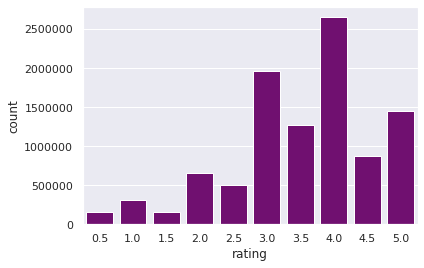

In [23]:
sns.countplot(train_df["rating"], color='purple');

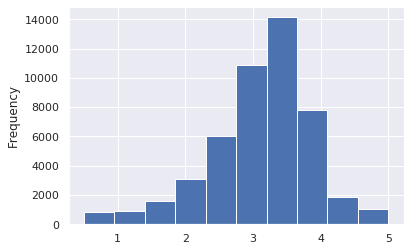

In [35]:
movies_rating = train_df[['movieId', 'rating']].groupby(by = 'movieId').mean()
movies_rating.sort_values(by = 'rating', ascending = False)
movies_rating["rating"] = round(movies_rating['rating'], 1)
movies_rating['rating'].plot(kind = 'hist')

#### Movies Df

In [36]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
basic_eda(movies_df)

The columns data types are as follows: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int32 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int32(1), object(2)
memory usage: 1.2+ MB
None 

The dataframe has datapoints totalling to: 

62423 

Checking the number of missing values in the columns 

movieId    0
title      0
genres     0
dtype: int64


In [19]:
len(movies_df['movieId'].unique())

62423

In [20]:
movies_df['genres'].value_counts().head(10)

Drama                   9056
Comedy                  5674
(no genres listed)      5062
Documentary             4731
Comedy|Drama            2386
Drama|Romance           2126
Horror                  1661
Comedy|Romance          1577
Comedy|Drama|Romance    1044
Drama|Thriller           933
Name: genres, dtype: int64

#### IMDB Df

In [22]:
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [23]:
basic_eda(imdb_df)

The columns data types are as follows: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int32  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float32
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float32(1), int32(1), object(4)
memory usage: 1.0+ MB
None 

The dataframe has datapoints totalling to: 

27278 

Checking the number of missing values in the columns 

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64


#### Links DF

In [24]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [25]:
basic_eda(links_df)

The columns data types are as follows: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int32  
 1   imdbId   62423 non-null  int32  
 2   tmdbId   62316 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 731.6 KB
None 

The dataframe has datapoints totalling to: 

62423 

Checking the number of missing values in the columns 

movieId      0
imdbId       0
tmdbId     107
dtype: int64


In [26]:
len(links_df['movieId'].unique())

62423

In [27]:
len(links_df['imdbId'].unique())

62423

In [28]:
len(links_df['tmdbId'].unique())

62282

#### Tags DF

In [29]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [30]:
basic_eda(tags_df)

The columns data types are as follows: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int32 
 1   movieId    1093360 non-null  int32 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 20.9+ MB
None 

The dataframe has datapoints totalling to: 

1093360 

Checking the number of missing values in the columns 

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64


In [31]:
tags_df['tag'].value_counts().head(10)

sci-fi                8330
atmospheric           6516
action                5907
comedy                5702
surreal               5326
based on a book       5079
twist ending          4820
funny                 4738
visually appealing    4526
dystopia              4257
Name: tag, dtype: int64

#### Genome Tags

In [32]:
getags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [33]:
basic_eda(getags_df)

The columns data types are as follows: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int16 
 1   tag     1128 non-null   object
dtypes: int16(1), object(1)
memory usage: 11.1+ KB
None 

The dataframe has datapoints totalling to: 

1128 

Checking the number of missing values in the columns 

tagId    0
tag      0
dtype: int64


In [34]:
len(getags_df['tagId'].unique())

1128

In [35]:
len(getags_df['tag'].unique())

1128

#### Genome Scores Df

In [36]:
gescores_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [37]:
basic_eda(gescores_df)

The columns data types are as follows: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int32  
 1   tagId      int16  
 2   relevance  float32
dtypes: float32(1), int16(1), int32(1)
memory usage: 148.6 MB
None 

The dataframe has datapoints totalling to: 

15584448 

Checking the number of missing values in the columns 

movieId      0
tagId        0
relevance    0
dtype: int64


In [38]:
len(gescores_df['movieId'].unique())

13816

In [39]:
len(gescores_df['tagId'].unique())

1128

In [40]:
gescores_df[['tagId', 'relevance']].groupby(['tagId']).mean().sort_values(by = 'relevance', ascending = False).head(10)

,relevance
tagId,
742,0.724424
646,0.541578
188,0.476752
468,0.475400
972,0.450228
867,0.447721
302,0.447113
452,0.428610
1104,0.422813


#### Test_DF

In [41]:
test_df.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [42]:
basic_eda(gescores_df)

The columns data types are as follows: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int32  
 1   tagId      int16  
 2   relevance  float32
dtypes: float32(1), int16(1), int32(1)
memory usage: 148.6 MB
None 

The dataframe has datapoints totalling to: 

15584448 

Checking the number of missing values in the columns 

movieId      0
tagId        0
relevance    0
dtype: int64


#### Exploratory Analysis of Joined Data Frames

##### Movies Meta Information

The movies_df has information about the title and genre of movies. We can enrich this by adding information about the title_cast, director, runtime, budget and plot_keywords which is contained in the imdb_df. In the following cell, we will join the two by merging on the Movie ID.

In [43]:
movies_meta_df = pd.merge(movies_df, imdb_df, how = 'left', on = 'movieId')

In [44]:
movies_meta_df.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Comedy|Romance,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [45]:
movies_meta_df['release_year'] = movies_meta_df["title"].str.extract(r"\((\d{4})\)$", expand=False)
movies_meta_df["release_year"] = pd.to_numeric(movies_meta_df["release_year"])
movies_meta_df["title"] = movies_meta_df.title.str.replace(r"\((\d{4})\)$", "")
movies_meta_df.head(2)

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,1995.0
2,3,Grumpier Old Men,Comedy|Romance,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...,1995.0
4,5,Father of the Bride Part II,Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,1995.0


In [46]:
movies_meta_df['genres'] = movies_meta_df['genres'].str.replace('|',' ')
movies_meta_df['plot_keywords'] = movies_meta_df['plot_keywords'].str.replace('|',' ')
movies_meta_df['title_cast'] = movies_meta_df['plot_keywords'].str.replace('|',' ')
movies_meta_df.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,release_year
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,toy rivalry cowboy cgi animation,John Lasseter,81.0,"$30,000,000",toy rivalry cowboy cgi animation,1995.0
1,2,Jumanji,Adventure Children Fantasy,board game adventurer fight game,Jonathan Hensleigh,104.0,"$65,000,000",board game adventurer fight game,1995.0
2,3,Grumpier Old Men,Comedy Romance,boat lake neighbor rivalry,Mark Steven Johnson,101.0,"$25,000,000",boat lake neighbor rivalry,1995.0
3,4,Waiting to Exhale,Comedy Drama Romance,black american husband wife relationship betra...,Terry McMillan,124.0,"$16,000,000",black american husband wife relationship betra...,1995.0
4,5,Father of the Bride Part II,Comedy,fatherhood doberman dog mansion,Albert Hackett,106.0,"$30,000,000",fatherhood doberman dog mansion,1995.0


movieId           0.00
title             0.00
genres            0.00
title_cast       76.96
director         75.41
runtime          78.34
budget           88.33
plot_keywords    76.96
release_year      0.91
dtype: float64


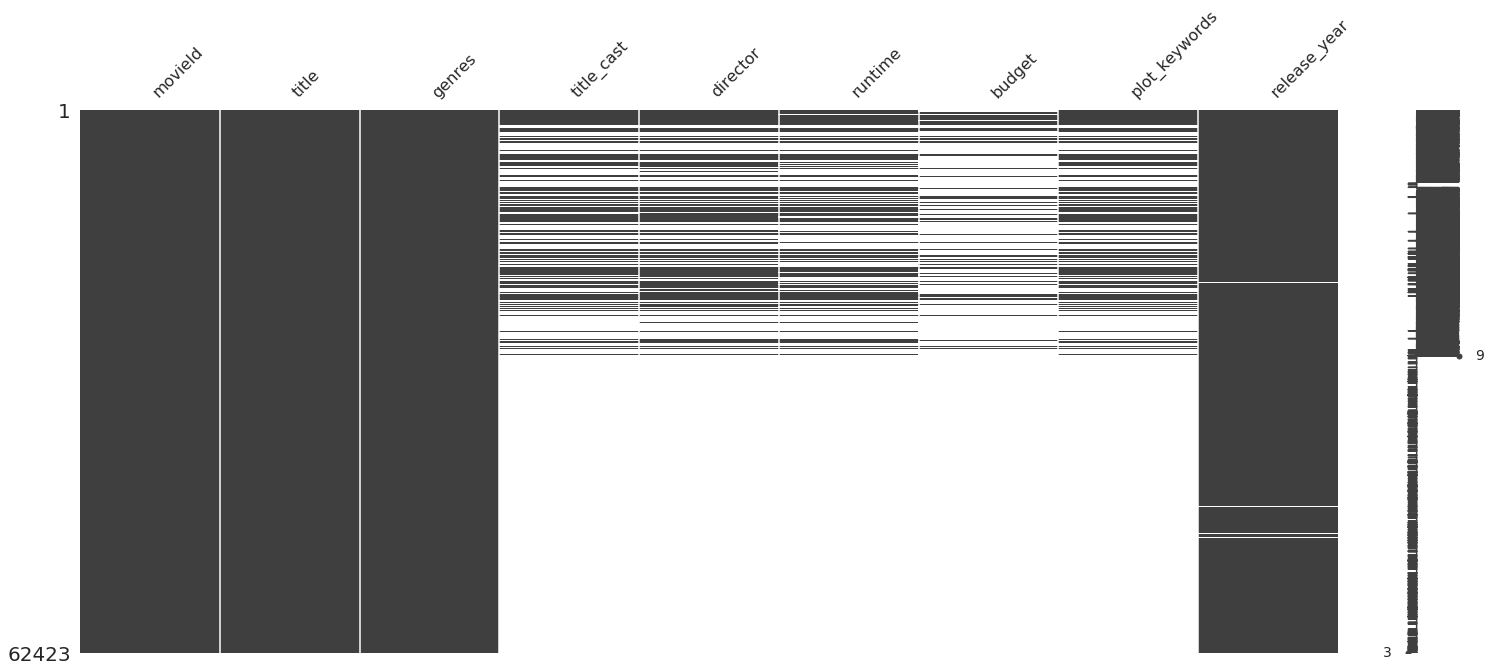

In [68]:
print(round(movies_meta_df.isna().sum()/movies_meta_df.isnull().count()*100, 2))
msno.matrix(movies_meta_df)
plt.show()

In [ ]:
movies_meta_df['release_year'] = pd.to_datetime(movies_meta_df['release_year']).dt.year
plt.figure(figsize = (10,6))
movies_meta_df['release_year'].plot(kind = 'bar', title = 'Number of Movies per year')

##### Genome Scores Meta Information

In [74]:
genome_df = pd.merge(gescores_df, getags_df, how = 'left', on = 'tagId')

<a id="three"></a>
## 3. FEATURE ENGINEERING
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

#### Dealing with Null Values

In [ ]:
# total = movies_meta_df.isnull().sum().sort_values(ascending=False)
# percent_1 = movies_meta_df.isnull().sum()/movies_meta_df.isnull().count()*100
# percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
# missing_data = pd.concat([total, percent_2],
#                          axis=1, keys=['Total', '(%) missing'])
# missing_data['(%) missing'].plot(kind='barh')
# plt.xlabel('(%) Missing Values')
# plt.ylabel('Columns with Missing Values')
# plt.title('Percentage of Missing Values per Column')
# plt.show()

In [53]:
round(movies_meta_df.isna().sum()/movies_meta_df.isnull().count()*100, 2)

movieId           0.00
title             0.00
genres            0.00
title_cast       76.96
director         75.41
runtime          78.34
budget           88.33
plot_keywords    76.96
release_year      0.91
dtype: float64

In [ ]:
columns = movies_meta_df.columns
drop_c = []
for i in columns:
    if (movies_meta_df[i].isnull().sum()/movies_meta_df[i].isnull().count()*100) > 70:
        drop_c.append(i)
movies_meta_df = movies_meta_df.drop(drop_c, axis =1)
movies_meta_df.head()

In [ ]:
genome_df.isna().sum()

#### Data Scaling

#### Dimension Reduction

<a id="four"></a>
## 4. MODELLING
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### Making the Recommender Engine

### Making the Ratings Predictions

In [9]:
#A00
train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']].head(750000), Reader())

In [10]:
#A00
train_set, test_set = train_test_split(train_data, test_size=0.05)

In [ ]:
#A00
#SVDpp model
svdpp=SVDpp(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)

#Fitting the model
svdpp.fit(train_set)

# Making prediction on the validation dataset
test_pred= svdpp.test(test_set)

#Evaluating model performance

In [ ]:
rsme_svdpp = accuracy.rmse(test_pred,
                             verbose=True)
rsme_svdpp

In [ ]:
#A00
pred_svdpp = [svdpp.predict(row.userId, row.movieId) for idx,row in test_df.iterrows()]

In [ ]:
#A00
svdpp_test_pred = pd.DataFrame(pred_svdpp)
svdpp_test_pred = svdpp_test_pred.rename(columns={'uid':'userId',
                                                          'iid':'movieId',
                                                          'est':'rating'})
svdpp_test_pred.head()

In [ ]:
#A00
svdpp_test_pred['Id']=svdpp_test_pred['userId'].astype(str) + '_' + svdpp_test_pred['movieId'].astype(str)
submission_df = svdpp_test_pred[['Id','rating']]
submission_df.head()

In [18]:
#A00
submission_df.to_csv('First_Svd_Model.csv', index=False)

### Logging Experiments on Comet

In [ ]:
# params = {"test_size": 0.3,
#           "model_type": "Bernoulli-Naive_Bayes",
#           "vectorizer": "tfidf vectorizer",
#           "param_grid": "None" ,
#           "stratify": True
#           }
# metrics = {"F1 score:": bnb_f1,
#            "Recall:": bnb_rec,
#            "Precision:": bnb_prec,
#            'Accuracy': bnb_acc
#            }
experiment_name = 'Comet Set Up'

In [ ]:
experiment.set_name(experiment_name)
# experiment.log_parameters(params)
# experiment.log_metrics(metrics)
experiment.end()

<a id="five"></a>
## 5. MODEL PERFORMANCE COMPARISON
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="six"></a>
## 6. MODEL EXPLANATIONS
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="seven"></a>
## 7. CONCLUSION
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="eight"></a>
## 8. APPENDIX
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>